# Path Integral Montecarlo


## Setup
This first part of the code is used to set up the input parameters for the code. 

In [1]:
#!/usr/bin/env python3
# -*- coding: utf-8 -*-
"""
Created on Thu May 16 17:50:33 2019

@author: SQUANCHY-MC
"""
%matplotlib notebook
import numpy as np
from scipy.interpolate import RegularGridInterpolator as rgi
from scipy.stats import linregress
from copy import deepcopy
from fast_histogram import histogram1d
import matplotlib.pyplot as plt



# RC - params . Better plots
plt.rcParams.update({'font.size': 25})
plt.rc("text", usetex = True)
plt.rc("font", family = "serif")
plt.rcParams['figure.subplot.hspace'] = 0.3
plt.rcParams['figure.subplot.wspace'] = 0.1
plt.rcParams['lines.linewidth'] = 4
plt.rcParams['axes.formatter.limits'] = -3 , 3
plt.rc('xtick.major', pad = 1)
plt.rc('ytick.major', pad = 1)
plt.rcParams['axes.labelpad'] = 15
plt.rcParams['axes.formatter.use_mathtext'] = False
plt.rcParams['figure.autolayout'] = True
plt.rcParams['figure.figsize'] =  7, 5.5  
# %%


# %%

"""Parameters, units: ueV, nm, ns"""

#N = 80 #time_steps and number of tried changes during one sweep.
num_path = 1000 #number of sweeps
print('num_paths = ', num_path)

#beta = 0.1 # imaginary total time? (/hbar?)
tau = 10 ** (-6)
print('tau = ', tau, '(ns)')

#time = np.linspace(0,beta,N)

delta_t = 0.5 # need to adjust for bias such that average acceptance rate is 0.5
h = 2 # tried position change (step size) during Metropolis is from [-h/2,h/2]
#h = np.sqrt(delta_t) # recommended by Stones?
print('delta_t, h = ',delta_t, h)

bias = 0 # Turn on/off force bias scheme (1 or 0)
interaction = 1 # Turn on/off electron-electron interaction (1 or 0)

if bias == 0:
    print('No Bias')
elif bias == 1:
    print('Bias')
if interaction == 0:
    print('No Interaction')
elif interaction == 1:
    print('Interaction')


num_paths =  1000
tau =  1e-06 (ns)
delta_t, h =  0.5 2
No Bias
Interaction


## List of Constants

In [2]:
me = 5.686 * 10 **(-6) # ueV ns^2/nm^2 - electron mass
mass = 1 # Effective mass on/off

if mass == 1:
        meff= 0.2 * me #effective electron mass in Silicon
        ml = 0.98 * me #effective mass in longitudinal k-direction
        mt = 0.19 * me #effective mass in transverse k-direction
        mx = mt #effective mass in x-direction
        my = mt #effective mass in y-direction
        mz = ml #effective mass in z-direction
        m = np.array([mx,my,mz])
        print('Mass')
else:
        print('No Mass')
    
# %%

hbar = 0.6582 # ueV * ns
a = 0.543 #nm - lattice constant in silicon
w = 4000/hbar
q = 10**6 # ueV
lamda = 0.5 * hbar**2 / me
r_0 = np.sqrt(hbar / (me*w))

E_z = 2 * 10**3 #ueV/nm - Electric field in z direction
pot_step = 3 * 10**6 #ueV - Si/SiO2 interface

# %%



Mass


## Methods for path generation, crossings and staying

In [3]:
def generate_path(N):
    '''path1 = np.zeros((3,N)) #Initial path: "Cold start"
    path2 = -25 * np.ones((3,N))
    for i in range(N):
    path2[1,i] = 0
    path2[2,i] = 0
    print('Cold Inital Path')'''
    pathx = np.random.uniform(-52,0,N)
    pathy = np.random.uniform(-10,10,N)
    pathz = np.random.uniform(-2,0,N)
    path = np.array([pathx,pathy,pathz])
    return path

#path1 = generate_path()
#path2 = generate_path()
#print('Hot Initial Path')

def crossing(path1,path2):
    path1[0][0] = -47.0
    path1[0][len(path1[0])-1] = -5.0
    path2[0][0] = 5.0
    path2[0][len(path2[0])-1] = -47.0
    print('Crossing')

def staying(path1,path2):
    path1[0][0] = -47.0
    path1[0][len(path1[0])-1] = -47.0
    path2[0][0] = -5.0
    path2[0][len(path2[0])-1] = -5.0
    print('Staying')



def create_TestPath(Num,Lamb):
    ''' Creates a test path to compare vectorized and non-vectorized voltatges
        Input: Num - number of points in the test path
        Return: Test path
    '''
    px = np.linspace(Lamb*(-52),0,Num)
    py = np.linspace(Lamb*(-10),Lamb*10,Num)
    pz = np.linspace(Lamb*(-2),0,Num)
    return np.array([px,py,pz])



## Non-vectorized Voltages 

In [9]:
"""Different potentials, all one dimensional"""    
def V_2d(x,y):
    return 0.5 * me * w**2 * (x**2 + y**2)

def dV_2d(x,y):
    return [me * w**2 * x, me * w**2 * y, 0]

x_0 = 1.5*r_0
def double_HO(x):
    return 0.5 * me * w**2 * min((x-x_0)**2,(x+x_0)**2)
    
def dV_double_HO(x):
    return [me * w**2 * min(x-x_0, x+x_0), 0, 0]
    
def V_HO1d(y):
    return 0.5 * me * w**2 * y**2

def dV_HO1d(y):
    return me * w**2 * y

# Heterostructure interface potential (z-direction) leading to airy functions as wave function.
a=10
slope = E_z
V = pot_step
def V_step(z):
    return(V / (np.exp(-a*z) + 1) + interpolate((0,0,z)))
    '''if z<0:
        return(V / (np.exp(a*z) + 1) - slope * z)
    elif z>2:
        return(slope *z)
    else:
        return(V / (np.exp(a*z) + 1) + slope * z)'''
    
def dV_step(z):
    return([0,0,-a * V * np.exp(a*z) / ((np.exp(a*z) + 1)**2)])
    '''if z<0:
        return([0,0,-a * V * np.exp(a*z) / ((np.exp(a*z) + 1)**2) - slope])
    elif z>2:
        return([0,0,slope])
    else:
        return([0,0,-a * V * np.exp(a*z) / ((np.exp(a*z) + 1)**2) + slope])'''

def dist(r1,r2):
    return(np.sqrt(np.dot(np.subtract(r1,r2),np.subtract(r1,r2))))

def ee(r1,r2):
    return(1.23*10**5/dist(r1,r2))

xs = np.load('UNSW4_1st withBG TEST ephiQWM UNSW4_1st structure 2nm 800x800 - 10-4-12-4.npz')['xs']
ys = np.load('UNSW4_1st withBG TEST ephiQWM UNSW4_1st structure 2nm 800x800 - 10-4-12-4.npz')['ys']
zs = np.load('UNSW4_1st withBG TEST ephiQWM UNSW4_1st structure 2nm 800x800 - 10-4-12-4.npz')['zs']
ephi = 10**6 * np.load('UNSW4_1st withBG TEST ephiQWM UNSW4_1st structure 2nm 800x800 - 10-4-12-4.npz')['ephi']

interpolate = rgi(points = (xs,ys,zs), values = ephi, bounds_error = False, method = 'nearest')

# interpolate = rgi(points = (xs,ys,zs), values = ephi, bounds_error = False)
def V_hrl(point):
    return interpolate(point)[0] + V_step(-point[2])

def V_doubledot(point):
    return double_HO(point[0]) + V_HO1d(point[1]) + V_step(point[2])

def dV_doubledot(point):
    return np.add(np.add(dV_double_HO(point[0]),dV_HO1d(point[1])),dV_step(point[2]))

def V_het(point): # Scalar potential of field @ position
    return V_2d(point[0],point[1]) + V_step(point[2])

def dV_het(point): # 3d gradient of field @ position
    return np.add(dV_2d(point[0],point[1]),dV_step(point[2]))

def dV_zero(point):
    return np.multiply(bias,[1,1,1])

'''V_field = V_doubledot
dV_field = dV_doubledot
print('Double Dot')'''
V_field = V_hrl
dV_field = dV_zero
print('HRL')



HRL


In [5]:
test_Path1 = create_TestPath(100,.3)
test_Path2 = create_TestPath(100,.8)
# find_action(test_Path1,test_Path2)
print(sum(test_Path1[0,:]),sum(test_Path2[0,:]))
np.mean(V_step(-test_Path1[2,:]))

prom = 0
for i in range(len(test_Path1[0,:])):
#     print(ee(test_Path1[:,i],test_Path2[:,i]))
#     print(V_field(test_Path1[:,i]))
    prom = prom + V_het(test_Path1[:,i])
prom
    

-780.0000000000002 -2080.0000000000005


31346559.53149384

In [6]:

# %%
    

def find_action(path1,path2): 
    """ returns action of system 
    I did an small modification to this code by changing the value of the derivative for a better aproximation 
    Inputs - two point paths
    return - the electron action 
    """
    s1 = 0
    s2 = 0
    V_interaction = 0
    for i in range(1,len(path1[0])-1):
        V_interaction += interaction * ee(path1[:,i],path2[:,i])
        s1 += 0.5 * (np.dot(m,(path1[:,i+1]-path1[:,i-1])**2)) / (4*tau) + tau * (V_field(path1[:,i]))# + V_interaction)
        s2 += 0.5 * (np.dot(m,(path2[:,i+1]-path2[:,i-1])**2)) / (4*tau) + tau * (V_field(path2[:,i]))# + V_interaction)
    s = s1 + s2 + 2 * np.log(2 * np.pi * tau / meff) + tau * V_interaction
    return s
   
""" Compares path w/o first element w/ path w/o last element, multiplying 0th*1st, 1st*2nd etc. and summing all sign changes """
def tunnelling_rate(path):
    localmax = 26
    tunnellings = (((path[0][:-1]+localmax) * (path[0][1:]+localmax)) < 0).sum() # +max to shift for potential to change for local max between dots
    rate = tunnellings/len(path)
    return tunnellings, rate

# %%



In [7]:
print(tau , m)

1e-06 [1.08034e-06 1.08034e-06 5.57228e-06]


In [8]:
test_Path1 = create_TestPath(100,.3)
test_Path2 = create_TestPath(100,.8)
# find_action(test_Path1,test_Path2)

import time
start_time = time.time()
for i in range(100):
    find_action(test_Path1,test_Path2)
print("Value of the action. ----", find_action(test_Path1,test_Path2))
print("--- %s seconds ---" % (time.time() - start_time))

Value of the action. ---- 538.2636303094538
--- 13.074028968811035 seconds ---


In [ ]:
125178.42965689918 41.91753840541765 145.0628419609732


Crossing
Staying
Crossing
Staying
Crossing
Staying
Crossing
Staying
Crossing
Staying
Crossing
Staying
Crossing
Staying
Crossing
Staying
Crossing
Staying
Crossing
Staying
--- 883.4579799175262 seconds ---


<IPython.core.display.Javascript object>


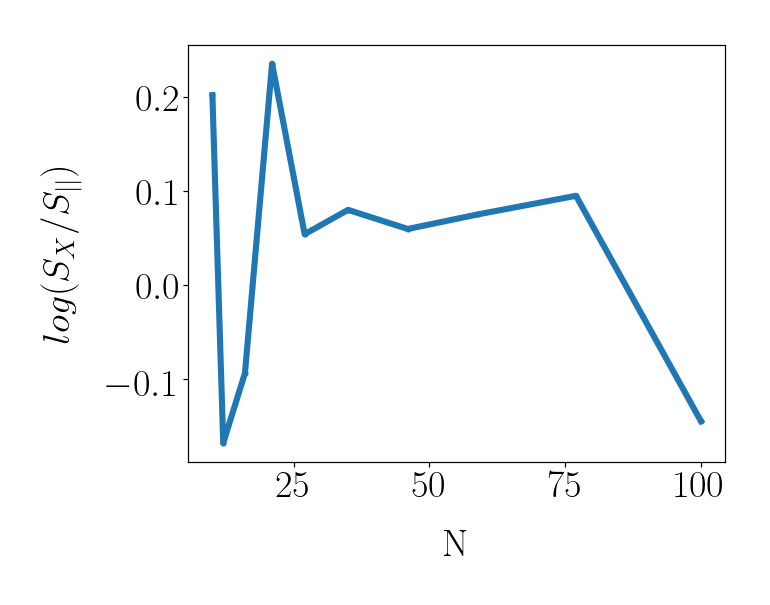

In [11]:

"""
One sweep consists of trying N times changing a random element in the array path (size of this change depends on h),
each time accepting/refusing according to Metropolis. 
"""

def sweep(path1,path2):
    N = len(path1[0])

    index=np.random.uniform(1,N-1,N) # Order in which path changes are tried. Endpoints (0 and N-1) kept fixed.
    metropolis_comparison = np.random.uniform(0,1,N)
    
    rand_x_1=np.random.uniform(0,1,N) # Creating N random numbers.
    rand_y_1=np.random.uniform(0,1,N)
    rand_z_1=np.random.uniform(0,1,N)
    
    rand_x_2=np.random.uniform(0,1,N) # Creating N random numbers.
    rand_y_2=np.random.uniform(0,1,N)
    rand_z_2=np.random.uniform(0,1,N)
    
    for i in range(0,N):
        time=int(index[i])
        time_m=int((time-1))
        time_p=int((time+1))
                
        """
        Calculating change in action due to replacing path[time] by x_new. Different potentials considered.
        """
                
        so1_px = (path1[0,time_p]-path1[0,time])**2
        so1_py = (path1[1,time_p]-path1[1,time])**2
        so1_pz = (path1[2,time_p]-path1[2,time])**2
        so1_mx = (path1[0,time]-path1[0,time_m])**2
        so1_my = (path1[1,time]-path1[1,time_m])**2
        so1_mz = (path1[2,time]-path1[2,time_m])**2
        
        so2_px = (path2[0,time_p]-path2[0,time])**2
        so2_py = (path2[1,time_p]-path2[1,time])**2
        so2_pz = (path2[2,time_p]-path2[2,time])**2
        so2_mx = (path2[0,time]-path2[0,time_m])**2
        so2_my = (path2[1,time]-path2[1,time_m])**2
        so2_mz = (path2[2,time]-path2[2,time_m])**2
        
        T_old1x = 0.5 * mx * (so1_px + so1_mx) / tau**2
        T_old1y = 0.5 * my * (so1_py + so1_my) / tau**2
        T_old1z = 0.5 * mz * (so1_pz + so1_mz) / tau**2
        T_old2x = 0.5 * mx * (so2_px + so2_mx) / tau**2
        T_old2y = 0.5 * my * (so2_py + so2_my) / tau**2
        T_old2z = 0.5 * mz * (so2_pz + so2_mz) / tau**2
        T_old1 = T_old1x + T_old1y + T_old1z
        T_old2 = T_old2x + T_old2y + T_old2z
        T_old = T_old1 + T_old2 # There would be a cleaner way to calculate this kinetic energy with dot products etc

        
        def V_spring(path):
            return np.dot(path[:,time_p] - path[:,time], path[:,time_p] - path[:,time]) / (4*lamda*tau) # different time?
        
        def dV_spring(path):
            return (path[:,time_p] - path[:,time] + path[:,time_m] - path[:,time]) / (4*lamda*tau)
        
        V_spring_old1 = V_spring(path1)
        V_spring_old2 = V_spring(path2) 
        dV_spring_old1 = dV_spring(path1)
        dV_spring_old2 = dV_spring(path2)
        
        V_field_old1 = V_field(path1[:,time])
        V_field_old2 = V_field(path2[:,time])
        dV_field_old1 = dV_field(path1[:,time])
        dV_field_old2 = dV_field(path2[:,time])

        V_interaction_old = interaction * ee(path1[:,time],path2[:,time])
        
        V_eff_old1 = V_field_old1 + V_spring_old1
        V_eff_old2 = V_field_old2 + V_spring_old2
        V_eff_old = V_eff_old1 + V_eff_old2 + V_interaction_old # For biased step
         
        dV_eff_old1 = dV_spring_old1 - 0.5 * tau * dV_field_old1
        dV_eff_old2 = dV_spring_old2 - 0.5 * tau * dV_field_old2
        
        E_old1 = T_old1 + V_field_old1 + V_interaction_old
        E_old2 = T_old2 + V_field_old2 + V_interaction_old
        E_old = E_old1 + E_old2 - V_interaction_old
        
        s_old1 = tau * E_old1
        s_old2 = tau * E_old2
        s_old = tau * E_old
        
        delta_r1 = delta_t * dV_eff_old1
        delta_r2 = delta_t * dV_eff_old2

        x_new_1 = path1[0,time] + bias * delta_r1[0] + h * (rand_x_1[i]-0.5)
        y_new_1 = path1[1,time] + bias * delta_r1[1] + h * (rand_y_1[i]-0.5)
        z_new_1 = path1[2,time] + bias * delta_r1[2] + h * (rand_z_1[i]-0.5)
        
        x_new_2 = path2[0,time] + bias * delta_r2[0] + h * (rand_x_2[i]-0.5)
        y_new_2 = path2[1,time] + bias * delta_r2[1] + h * (rand_y_2[i]-0.5)
        z_new_2 = path2[2,time] + bias * delta_r2[2] + h * (rand_z_2[i]-0.5)
        
        r_new_1 = [x_new_1,y_new_1,z_new_1]
        r_new_2 = [x_new_2,y_new_2,z_new_2]

        sn1_px = (path1[0,time_p]-r_new_1[0])**2
        sn1_py = (path1[1,time_p]-r_new_1[1])**2
        sn1_pz = (path1[2,time_p]-r_new_1[2])**2
        sn1_mx = (r_new_1[0]-path1[0,time_m])**2
        sn1_my = (r_new_1[1]-path1[1,time_m])**2
        sn1_mz = (r_new_1[2]-path1[2,time_m])**2
        
        sn2_px = (path2[0,time_p]-r_new_2[0])**2
        sn2_py = (path2[1,time_p]-r_new_2[1])**2
        sn2_pz = (path2[2,time_p]-r_new_2[2])**2
        sn2_mx = (r_new_2[0]-path2[0,time_m])**2
        sn2_my = (r_new_2[1]-path2[1,time_m])**2
        sn2_mz = (r_new_2[2]-path2[2,time_m])**2
        
        T_new1x = 0.5 * mx * (sn1_px + sn1_mx) / tau**2
        T_new1y = 0.5 * my * (sn1_py + sn1_my) / tau**2
        T_new1z = 0.5 * mz * (sn1_pz + sn1_mz) / tau**2
        T_new2x = 0.5 * mx * (sn2_px + sn2_mx) / tau**2
        T_new2y = 0.5 * my * (sn2_py + sn2_my) / tau**2
        T_new2z = 0.5 * mz * (sn2_pz + sn2_mz) / tau**2
        T_new1 = T_new1x + T_new1y + T_new1z
        T_new2 = T_new2x + T_new2y + T_new2z
        T_new = T_new1 + T_new2
        
        V_field_new1 = V_field(r_new_1)
        V_field_new2 = V_field(r_new_2)
        V_field_new = V_field_new1 + V_field_new2
       
        V_interaction_new = interaction * ee(r_new_1,r_new_2)

        E_new1 = T_new1 + V_field_new1 + V_interaction_new
        E_new2 = T_new2 + V_field_new2 + V_interaction_new
        E_new = E_new1 + E_new2 - V_interaction_new
        
        s_new1 = tau * E_new1
        s_new2 = tau * E_new2
        s_new = tau * E_new

        delta_s1 = s_new1 - s_old1
        delta_s2 = s_new2 - s_old2
        delta_s = s_new - s_old
        
        def transition_exponent(old_point,new_point):
            return np.dot(new_point - old_point - delta_t * dV_field(old_point), new_point - old_point - delta_t * dV_field(old_point)) / (2 * delta_t)
        
        def accept(old_path,new_path):
            old_path = new_path
        
        if bias == 0:
            if interaction == 1:
                if delta_s < 0: # always accepting if action lowered
                    accept(path1[:,time],r_new_1)
                    accept(path2[:,time],r_new_2)
                elif metropolis_comparison[i]<np.exp(-(delta_s/hbar)): #otherwise accepte with specific probability.
                    accept(path1[:,time],r_new_1)
                    accept(path2[:,time],r_new_2)
            else:
                if delta_s1 < 0: # always accepting if action lowered
                    accept(path1[:,time],r_new_1)
                elif metropolis_comparison[i]<np.exp(-(delta_s1/hbar)): #otherwise accepte with specific probability.
                    accept(path1[:,time],r_new_1)
                if delta_s2 < 0: # always accepting if action lowered
                    accept(path2[:,time],r_new_2)
                elif metropolis_comparison[i]<np.exp(-(delta_s2/hbar)): #otherwise accepte with specific probability.
                    accept(path2[:,time],r_new_2)
        else:
            mu1 = transition_exponent(r_new_1,path1[:,time])
            mu2 = transition_exponent(r_new_2,path2[:,time])
            nu1 = transition_exponent(path1[:,time],r_new_1)
            nu2 = transition_exponent(path2[:,time],r_new_2)
            if nu1 - mu1 + E_old1 - E_new1 > 0: # avoides exponential calculation
                accept(path1[:,time],r_new_1)
            elif metropolis_comparison[i] < np.exp(nu1 - mu1 + E_old1 - E_new1):
                accept(path1[:,time],r_new_1)
            if nu2 - mu2 + E_old2 - E_new2 > 0: # avoides exponential calculation
                accept(path2[:,time],r_new_2)
            elif metropolis_comparison[i] < np.exp(nu2 - mu2 + E_old2 - E_new2):
                accept(path2[:,time],r_new_2)

# %%
                
"""
Returns actions for a crossing or staying system for different N
Might need to fix these, changed them slightly to run on NCI
"""

def perform_pederson(path1,path2): # simply updates paths
    for j in range(num_path):
        sweep(path1,path2)

N_list = np.logspace(1,2,10).astype(int) # N's from 10^1 to 10^3, 10 elements
#print(N_list)

crossing_action_list = [0] * len(N_list)
staying_action_list = [0] * len(N_list)

def find_crossing_actions(N):
    path1crossing = generate_path(N)
    path2crossing = generate_path(N)
    crossing(path1crossing,path2crossing)
    perform_pederson(path1crossing,path2crossing)
    return(N,find_action(path1crossing,path2crossing))

def find_staying_actions(N):
    path1staying = generate_path(N)
    path2staying = generate_path(N)
    staying(path1staying,path2staying)
    perform_pederson(path1staying,path2staying)
    return(N,find_action(path1staying,path2staying))

def find_pederson_actions(N):
    return (find_crossing_actions(N)[1], find_staying_actions(N)[1])

def pederson():
    for i in range(len(N_list)):
        crossing_action_list[i] = find_crossing_actions(N_list[i])[1]
        staying_action_list[i] = find_staying_actions(N_list[i])[1]
        


# %%
        


def exchange_coupling():
    slope = linregress(N_list[-int(len(N_list)/4):],action_ratio_list[-int(len(N_list)/4):])[0]
    J = slope / tau
    print('J = ',J,'(ueV)')
    print('J = ',J/hbar,'(nHz)')
    return J
#exchange_coupling()

# %%

# import time
start_time = time.time()



# Running the main code
pederson()
action_ratio_list = np.divide(crossing_action_list,staying_action_list)
print("--- %s seconds ---" % (time.time() - start_time))

plt.plot(N_list,np.log(action_ratio_list),'.-')
plt.xlabel('N')
plt.ylabel('$log(S_X/S_{||})$')
plt.show()

